A measure of how far a car can travel if you put just one gallon of petrol or diesel in its tank

Explanation on MSRP

MSRP is the manufacturer's suggested retail price, a price recommended for the sale of an item in all retail outlets. A vendor can require retailers to sell its products at the MSRP and refuse to sell its products to a discounter if they price products below it.

> - Prices retained
> 
>     ◦ for vehicles sold in 2017 (1 668 vehicles), new price suggested by the manufacturer
>
>     ◦ for used vehicles (10 246 vehicles), edmunds.com True Market Value
>     
This difference in method could lead to a discontinuity. However we see on different examples there isn't any significant gap.
> 
> - All prices are recorded at the same time and can be compared. There is no need for inflation ajustment.
> 
> - Used car prices are floored on edmunds.com. Oldest or cheapest vehicles have a minimum price of 2000 USD (1 036 vehicles).

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import xgboost as xgb
import lightgbm as lgb
from sklearn import  ensemble
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

import time
import shap

In [9]:
df_cleaned = pd.read_csv("./data/cars_cleaned.csv").drop('Unnamed: 0', axis=1)
df_cleaned.head(5)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,0,335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,0,300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,0,300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,0,230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,0,230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [11]:
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

d = defaultdict(LabelEncoder)

# remove duplicate column names
columns_to_encode = list(dict.fromkeys([
    "Make",
    "Model",
    "Engine Fuel Type",
    "Transmission Type",
    "Driven_Wheels",
    "Market Category",
    "Vehicle Size",
    "Vehicle Style"
]))

df_cleaned[columns_to_encode] = df_cleaned[columns_to_encode].apply(
    lambda x: d[x.name].fit_transform(x.fillna("0"))
)

df_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  int64  
 1   Model              11914 non-null  int64  
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11914 non-null  int64  
 4   Engine HP          11914 non-null  float64
 5   Engine Cylinders   11914 non-null  float64
 6   Transmission Type  11914 non-null  int64  
 7   Driven_Wheels      11914 non-null  int64  
 8   Number of Doors    11914 non-null  float64
 9   Market Category    11914 non-null  int64  
 10  Vehicle Size       11914 non-null  int64  
 11  Vehicle Style      11914 non-null  int64  
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(1

In [12]:
# GET DUMMIES, FEATURES SELECTION, PROPERLY CLEANED AND INPUTED DATAS

df_cleaned_dummies = df_cleaned.copy()
df_cleaned_dummies = pd.get_dummies(df_cleaned_dummies)

X = df_cleaned_dummies.drop(['MSRP'], axis=1)
y = df_cleaned_dummies['MSRP']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.4, random_state = 42)

# Need index of car prices to predict, whatever the strategy is
indexes_cars_predicted = X_test.index

##### How to chose NUM_OF_FEATURES to select ?</font>

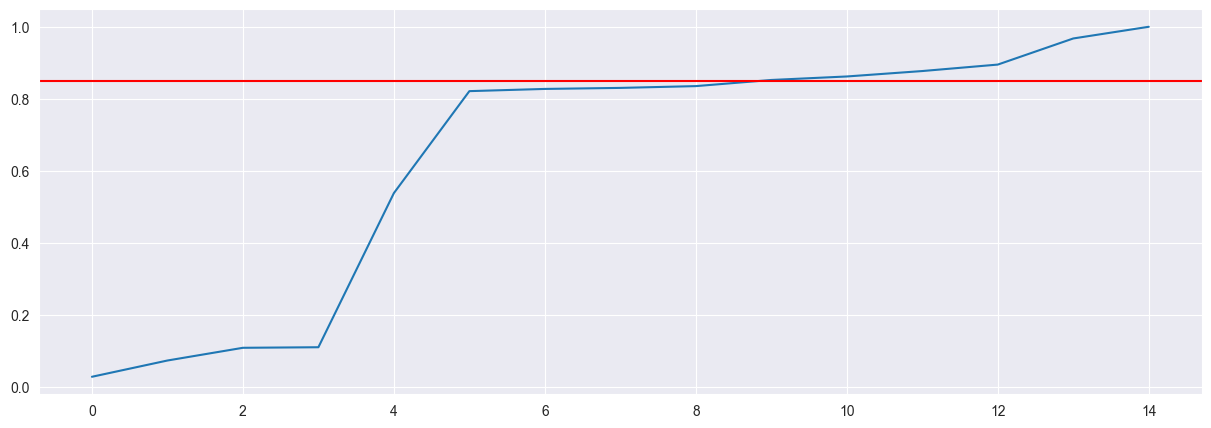

In [14]:
def rmsle(predicted, real):
    sum=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

NUM_OF_FEATURES = X.shape[1]

train_X_train, train_X_test, train_y_train, train_y_test = train_test_split(X_train, y_train, test_size=0.2)

model = ensemble.RandomForestRegressor(n_jobs=-1, n_estimators = 100, random_state=42)
model.fit(train_X_train, train_y_train)

# Graphs section
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(111)
plt.plot(np.cumsum(model.feature_importances_))
plt.axhline(0.85,color= 'r')

NUM_OF_FEATURES = 200

col = pd.DataFrame({'importance': model.feature_importances_, 'feature': X_train.columns}).sort_values(
    by=['importance'], ascending=[False])[:NUM_OF_FEATURES]['feature'].values

X_train = X_train[col]
X_test = X_test[col]

#### LGBM vs XGBOOST</font>

In [15]:
# Define evaluation method for a given model. we use k-fold cross validation on the training set. 
# The loss function is root mean square logarithm error between target and prediction
# Note: train and y_train are feeded as global variables

NUM_FOLDS = 5
def rmsle_cv(model,strategy):
        kf = KFold(NUM_FOLDS, shuffle=True, random_state=42).get_n_splits(X_train.values)
        rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
        return(rmse)

# Ensemble method: model averaging
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # We define clones of the original models to fit the data in
    # the reason of clone is avoiding affect the original base models
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]  
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)
        return self
    
    # Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([ model.predict(X) for model in self.models_ ])
        return np.mean(predictions, axis=1)

model_xgb = xgb.XGBRegressor(colsample_bytree=0.055, 
                             gamma=1.5, 
                             learning_rate=0.02, 
                             max_depth=12, 
                             n_estimators=1000,
                             subsample=0.7, 
                             objective='reg:linear',
                             booster='gbtree',
                             reg_alpha=0.0, 
                             eval_metric = 'rmse', 
                             silent=1, 
                             random_state =7,
                            )

model_lgb = lgb.LGBMRegressor(objective='regression',
                              num_leaves=144,
                              learning_rate=0.005, 
                              n_estimators=1000, 
                              max_depth=12,
                              metric='rmse',
                              is_training_metric=True,
                              max_bin = 55, 
                              bagging_fraction = 0.8,
                              verbose=-1,
                              bagging_freq = 5, 
                              feature_fraction = 0.9)

l_m = []
l_std = []
time_d = {}

print("GET DUMMIES, FEATURES SELECTION, KEEP MISSING VALUES\n")

start = time.time()
score_1 = rmsle_cv(model_xgb,1)
end = time.time()

l_m.append(score_1.mean())
l_std.append(score_1.std())
time_d['XGB']= end - start
print("    Xgboost score : {:.4f} ({:.4f})".format(score_1.mean(), score_1.std()))

start = time.time()
score_1 = rmsle_cv(model_lgb,1)
end = time.time()

l_m.append(score_1.mean())
l_std.append(score_1.std())
time_d['LGB']= end - start
print("    LGBM score    : {:.4f} ({:.4f})" .format(score_1.mean(), score_1.std()))

averaged_models_1 = AveragingModels(models = (model_xgb, model_lgb))

score_1 = rmsle_cv(averaged_models_1,1)

l_m.append(score_1.mean())
l_std.append(score_1.std())
print("    Averaged score: {:.4f} ({:.4f})\n" .format(score_1.mean(), score_1.std()))

print('\nLGB faster than XGB ?',time_d['LGB']>time_d['XGB'])

GET DUMMIES, FEATURES SELECTION, KEEP MISSING VALUES



C:\Users\gyanr\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:38:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\gyanr\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:38:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\gyanr\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:38:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\gyanr\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: User

    Xgboost score : 23337.6572 (8978.8791)
    LGBM score    : 27587.4812 (9543.3382)


C:\Users\gyanr\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:38:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\gyanr\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:38:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\gyanr\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:38:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:245: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\gyanr\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: User

    Averaged score: 23035.3468 (9689.2730)


LGB faster than XGB ? True


LGBM is a great solution if your PC runs slowly, hence the word 'light'. It trains faster than XGBOOST. However I don't manipulate a significant amount of datas and given the way each algorithm is parametrized, the computation depends. On average LGBM is performs faster but with less accuracy than XGB.

#### 4.6 The best model</font>

In [16]:
model_lgb.fit(X_train.values, y_train)
pred = model_lgb.predict(X_test.values)

C:\Users\gyanr\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


#### 5.1 What is a SHAP value</font>

SHAP is a unified approach to explain the output of any machine learning model. SHAP connects game theory with local explanations, representing the only possible consistent and locally accurate additive feature attribution method based on expectations (More details : http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions).

In [17]:
# load JS visualization code to notebook
shap.initjs()

In [18]:
# Using a random sample of the dataframe for better time computation
X_sampled = X_train.sample(100, random_state=10)

### explain the model's predictions using SHAP values
### (same syntax works for LightGBM, CatBoost, and scikit-learn models)

In [19]:
explainer = shap.TreeExplainer(model_lgb)
shap_values = explainer.shap_values(X_sampled)

In [26]:
# visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_sampled.iloc[0,:])

### If the above did not render due to javascript issues, below is the matplotlib version

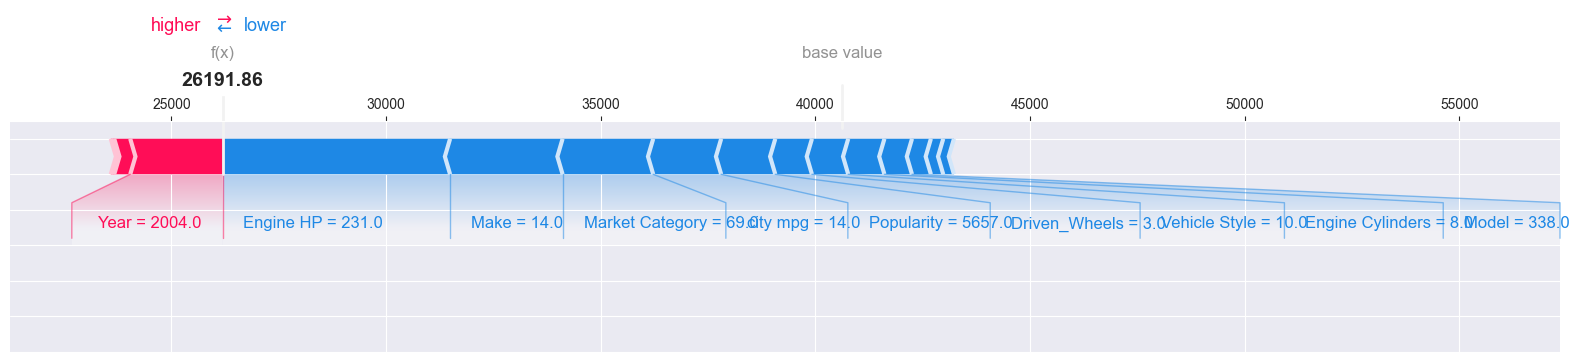

In [28]:
shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    X_sampled.iloc[0],
    matplotlib=True
)

plt.show()


The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue (these force plots are introduced in our Nature BME paper).

In [36]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_train)




To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. SHAP values represent a feature's responsibility for a change in the model output. Vertical dispersion represents interaction effects with other features. To help reveal these interactions dependence_plot automatically selects another feature for coloring.

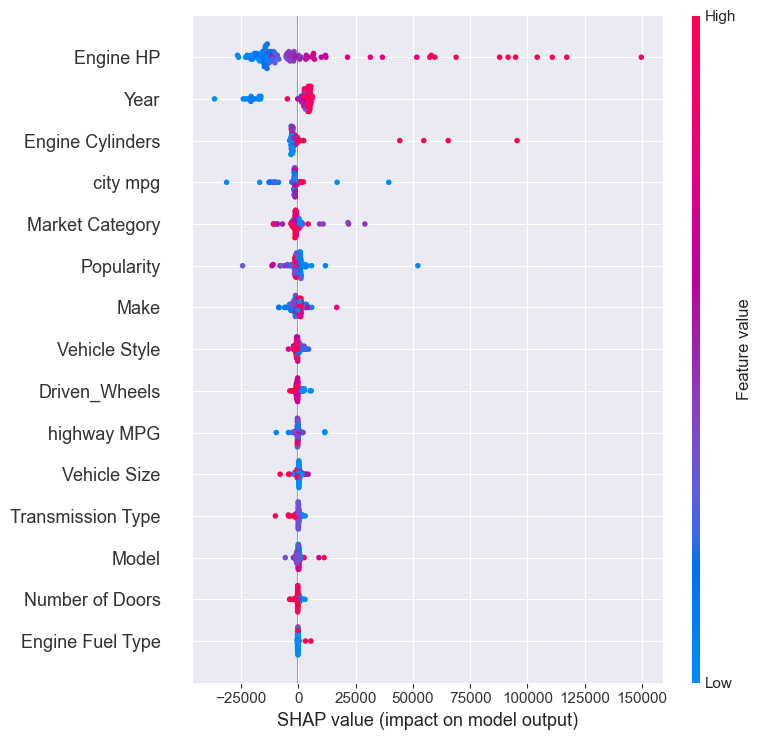

In [37]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_sampled)

We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot (produces stacked bars for multi-class outputs):

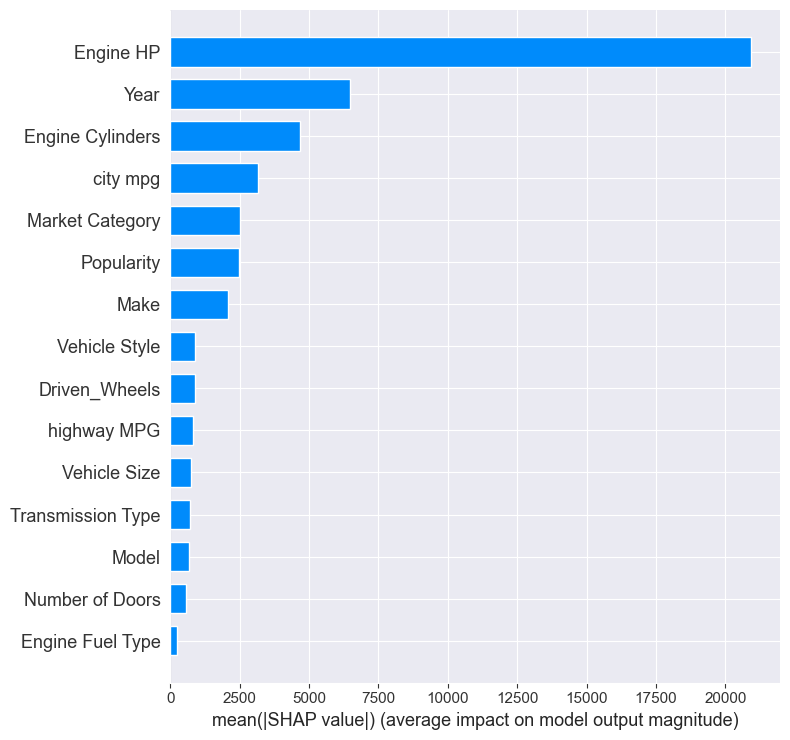

In [23]:
shap.summary_plot(shap_values, X_sampled, plot_type="bar")

Given that representative sample, when someone wants to buy a car, the criterias will be the city mpg, the car age and the engine HP of the car.

##  6. Predictions</div>

Over 4766 cars, the average gap between the predicted price and the real price is 4372.0 $


C:\Users\gyanr\AppData\Local\Temp\ipykernel_7212\1332001443.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pred, color="blue", label="Distrib Predictions", hist = False)
C:\Users\gyanr\AppData\Local\Temp\ipykernel_7212\1332001443.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sn

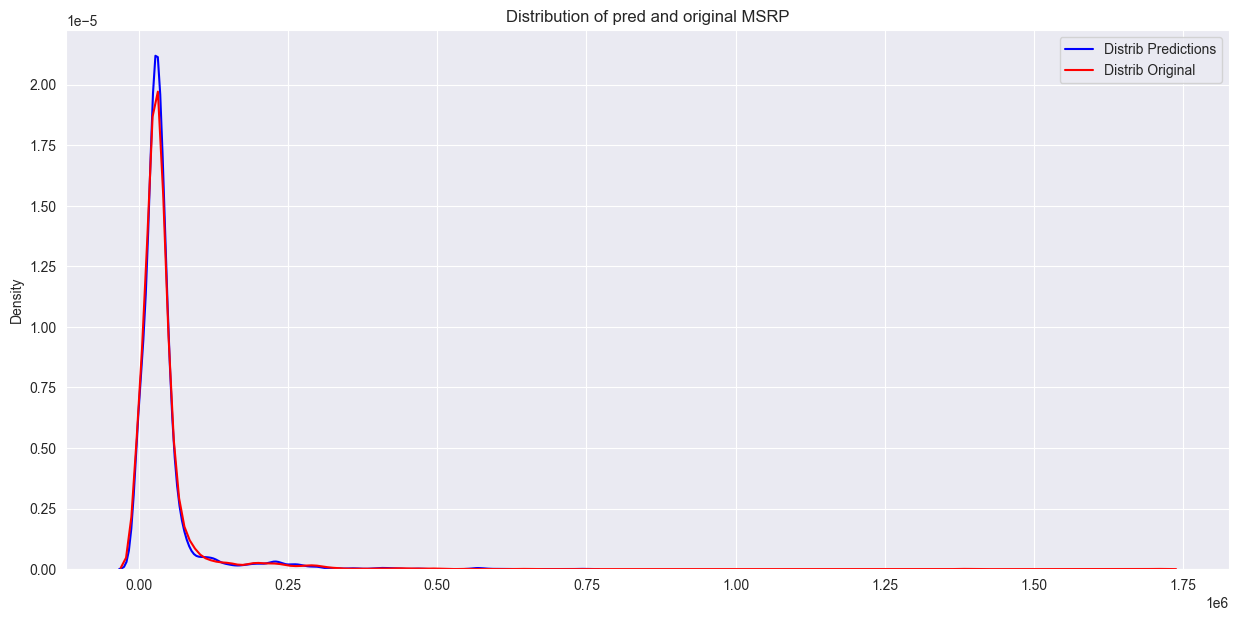

In [24]:
pred = np.array(pred)
original = np.array(df_cleaned_dummies.loc[indexes_cars_predicted,'MSRP'])

df_cleaned_dummies.loc[indexes_cars_predicted,'MSRP']

def average_gap(l1,l2):
    resu=0
    for i in range(len(l1)):
        resu += np.abs(l1[i]-l2[i])
    resu = resu/len(l1)
    return(resu)

print("Over",len(pred),"cars, the average gap between the predicted price and the real price is",round(average_gap(pred,original),0),"$")

plt.figure(figsize=(15,7))
sns.distplot(pred, color="blue", label="Distrib Predictions", hist = False)
sns.distplot(original, color="red", label="Distrib Original", hist = False)
plt.title("Distribution of pred and original MSRP")
plt.legend()

## Conclusion

To improve the model, some features could be added such as the weight of the car, the nationality of the car manufacturer, options sold with the car and many others.